In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Baseline: linear regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load the standardized dataset
df = pd.read_csv('/content/drive/MyDrive/fc25_train_GK.csv')  # 或你本地路径

# 2. Construct X and y
target = 'market_value_million'
X = df.drop(columns=[target])
y = df[target]

# 3. CV settings
seeds = [91, 22, 67, 2025, 623]
n_splits = 5

rmse_list, mae_list, r2_list = [], [], []

# 4. Train and validate with multiple seeds
for seed in seeds:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for tr_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        model = LinearRegression()
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        mae_list.append(mean_absolute_error(y_val, y_pred))
        r2_list.append(r2_score(y_val, y_pred))

# 5. Output results
print("LinearRegression — 5 seeds × 5 folds results:")
print(f"Total folds: {len(rmse_list)}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE : {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"R²  : {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")


LinearRegression — 5 seeds × 5 folds results:
Total folds: 25
RMSE: 2.9050 ± 0.3933
MAE : 1.7505 ± 0.0981
R²  : 0.3968 ± 0.1670


In [ ]:
# 3. 读取处理好的训练集和测试集
train_file = '/content/drive/MyDrive/fc25_train_GK.csv'
test_file  = '/content/drive/MyDrive/fc25_test_GK.csv'
train_df = pd.read_csv(train_file)
test_df  = pd.read_csv(test_file)

# 4. 定义要排除的列
exclude = ['market_value_million']

# 5. 构造训练和测试的特征矩阵 X 和目标向量 y
X_train = train_df.drop(columns=exclude)
y_train = train_df['market_value_million']
X_test  = test_df.drop(columns=exclude)
y_test  = test_df['market_value_million']

# 6. 训练最终模型
lr = LinearRegression()
lr.fit(X_train, y_train)
assert list(X_train.columns) == list(X_test.columns), "Train/test columns do not match!"

# 7. 在测试集上预测并评估
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Test Set Evaluation:")
print(f"Samples: {len(y_test)}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


Test Set Evaluation:
Samples: 334
RMSE: 3.1116
MAE : 1.7192
R²  : 0.4864


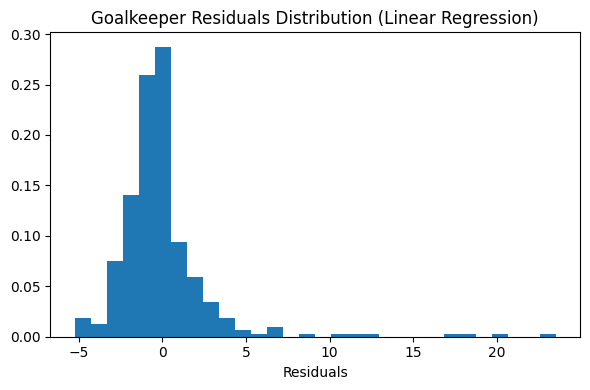

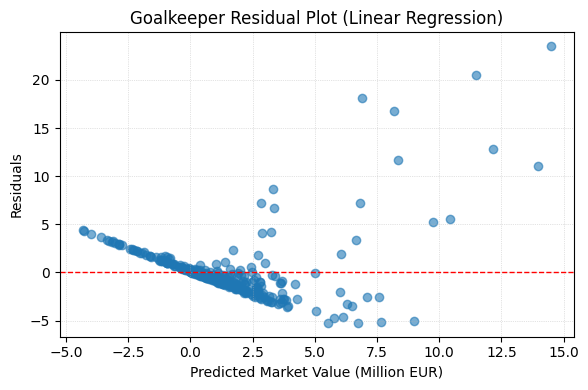

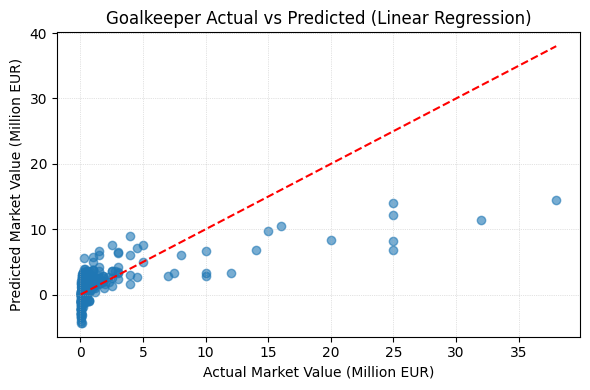

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# 生成残差
residuals = y_test - y_pred

# 1) 残差分布直方图
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, density=True)
plt.xlabel("Residuals")
plt.title("Goalkeeper Residuals Distribution (Linear Regression)")
plt.tight_layout()
plt.show()

# 2) 预测值 vs 残差 散点图
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Market Value (Million EUR)")
plt.ylabel("Residuals")
plt.title("Goalkeeper Residual Plot (Linear Regression)")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# 3) 实际值 vs 预测值 散点图（替代 Q-Q 图）
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 理想参考线
plt.xlabel("Actual Market Value (Million EUR)")
plt.ylabel("Predicted Market Value (Million EUR)")
plt.title("Goalkeeper Actual vs Predicted (Linear Regression)")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 3. 读取训练集
train_file = '/content/drive/MyDrive/fc25_train_GK.csv'  # 修改为你的文件名
df = pd.read_csv(train_file)

# 4. 构造特征 X 和目标 y
exclude = ['market_value_million']
X = df.drop(columns=exclude)
y = df['market_value_million']

# 5. 定义种子列表和折数
seeds = [91, 22, 67, 2025, 623]
n_splits = 5

# 6. 存储所有折次的评估结果
rmse_scores, mae_scores, r2_scores = [], [], []

# 7. 循环随机种子 + KFold
for seed in seeds:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 初始化并训练 Random Forest
        rf = RandomForestRegressor(
            n_estimators=100,
            max_features='sqrt',
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            bootstrap=True,
            random_state=42,
            n_jobs=-1)

        rf.fit(X_tr, y_tr)
        y_pred = rf.predict(X_val)

        # 计算并收集指标
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        mae_scores.append(mean_absolute_error(y_val, y_pred))
        r2_scores.append(r2_score(y_val, y_pred))

# 8. 输出汇总结果
print("Random Forest 5-seed, 5-fold CV on training set:")
print(f"Folds evaluated: {len(rmse_scores)}")
print(f"RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"MAE : {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"R²  : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Random Forest 5-seed, 5-fold CV on training set:
Folds evaluated: 25
RMSE: 2.2832 ± 0.4078
MAE : 0.9072 ± 0.1229
R²  : 0.6199 ± 0.1534


In [ ]:


import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer, mean_absolute_error

df = pd.read_csv('/content/drive/MyDrive/fc25_train_GK.csv')
exclude = ['market_value_million']
X_att = df.drop(columns=exclude)
y_att = df['market_value_million']

# 2. 定义模型和超参空间
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_dist = {
    'n_estimators':      randint(100,300),     # 100–300 棵树
    'max_depth':         [None] + list(range(5, 21)),
    'min_samples_split': randint(2, 11),         # 分裂所需最少样本 2–8
    'min_samples_leaf':  randint(1, 6),         # 叶子最少样本 1–5
    'max_features':       ['sqrt', 'log2', 0.3, 0.5, 0.7],  # 0.3–0.7
    'bootstrap':         [True, False]
}

# 3. 定义 CV 与 MAE scorer
cv = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 4. RandomizedSearchCV
search_att = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,             # 尝试 120 组参数
    scoring=mae_scorer,     # 以 MAE 最小作为目标
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1,
    refit=True              # 自动在全 X_att,y_att 上 refit
)

# 5. 运行超参搜索
search_att.fit(X_att, y_att)

# 6. 输出最优参数 & CV MAE
print("Best params for Goalkeeper subset:", search_att.best_params_)
print("Best CV MAE (million EUR):", -search_att.best_score_)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params for Goalkeeper subset: {'bootstrap': False, 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 138}
Best CV MAE (million EUR): 0.772685824621868


In [ ]:


# 2. 导入库
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 3. 读取数据
df = pd.read_csv('/content/drive/MyDrive/fc25_train_GK.csv')
exclude = ['market_value_million']
X = df.drop(columns=exclude)
y = df['market_value_million']

# 4. 最优参数（替换成你实际的 best_params 字典）
best_params = search_att.best_params_

# 5. 5-seed, 5-fold CV
seeds = [91, 22, 67, 2025, 623]
n_splits = 5

rmse_list, mae_list, r2_list = [], [], []

for seed in seeds:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 6. 用 best_params 初始化模型
        rf = RandomForestRegressor(
            **best_params,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_tr, y_tr)
        y_pred = rf.predict(X_val)

        # 7. 计算指标
        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        mae_list.append(mean_absolute_error(y_val, y_pred))
        r2_list.append(r2_score(y_val, y_pred))

# 8. 输出汇总
print("5-seed, 5-fold CV with tuned RF on Goalkeepers train:")
print(f"Total folds: {len(rmse_list)}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE : {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"R²  : {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")
print("Best Parameters Used:", best_params)

5-seed, 5-fold CV with tuned RF on Goalkeepers train:
Total folds: 25
RMSE: 2.2300 ± 0.4136
MAE : 0.8267 ± 0.1229
R²  : 0.6308 ± 0.1689
Best Parameters Used: {'bootstrap': False, 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 138}


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 3. 读取训练集
train_file = '/content/drive/MyDrive/fc25_train_GK.csv'  # 修改为你的文件名
df = pd.read_csv(train_file)

# 4. 构造特征 X 和目标 y
exclude = ['market_value_million']
X_train = df.drop(columns=exclude)
y_train = df['market_value_million']
# 假设 best_params 是你从 RandomizedSearchCV 得到的字典

# best_params_ 是字典，里面包含了最优超参数
best_params = search_att.best_params_

# 用这些参数再构造一个新的 RandomForestRegressor
rf_final = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

# 然后在整个训练集上训练
rf_final.fit(X_train, y_train)


RandomForestRegressor(bootstrap=False, max_depth=8, max_features=0.5,
                      min_samples_leaf=2, min_samples_split=6, n_estimators=138,
                      n_jobs=-1, random_state=42)

In [ ]:
# 3. 读取处理好的训练集和测试集
train_file = '/content/drive/MyDrive/fc25_train_GK.csv'
test_file  = '/content/drive/MyDrive/fc25_test_GK.csv'
train_df = pd.read_csv(train_file)
test_df  = pd.read_csv(test_file)

# 4. 定义要排除的列
exclude = ['market_value_million']

# 5. 构造训练和测试的特征矩阵 X 和目标向量 y
X_train = train_df.drop(columns=exclude)
y_train = train_df['market_value_million']
X_test  = test_df.drop(columns=exclude)
y_test  = test_df['market_value_million']


# 7. 在测试集上预测并评估

y_pred_1 = rf_final.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_1))
mae  = mean_absolute_error(y_test, y_pred_1)
r2   = r2_score(y_test, y_pred_1)

print("Test Set Evaluation:")
print(f"Samples: {len(y_test)}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

Test Set Evaluation:
Samples: 334
RMSE: 2.0121
MAE : 0.7890
R²  : 0.7853


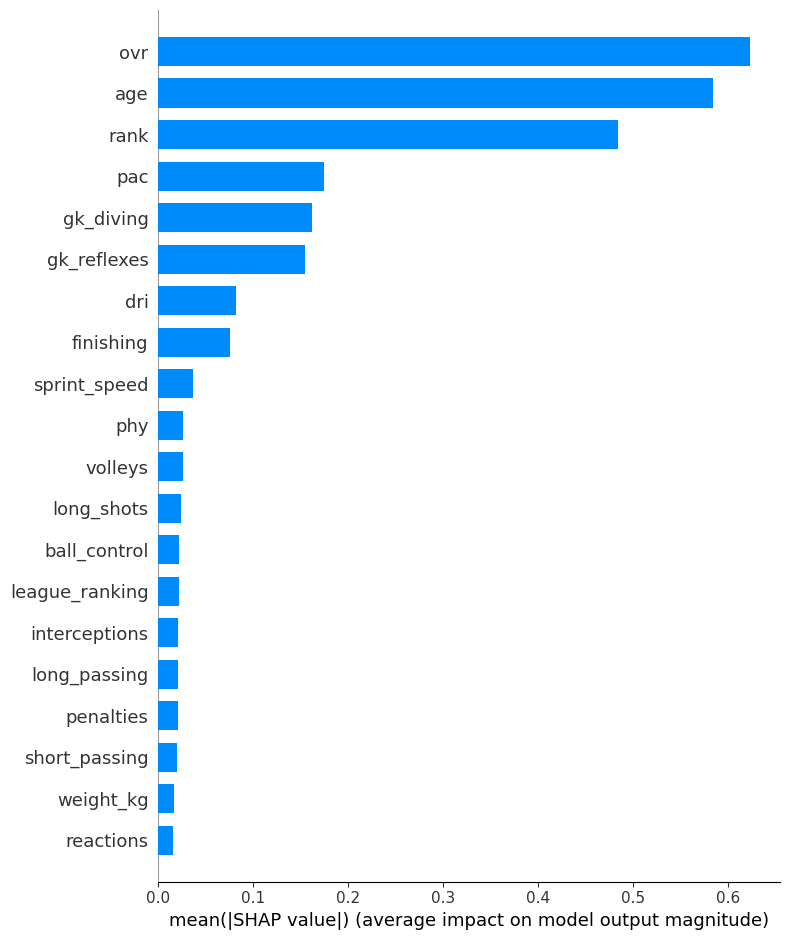

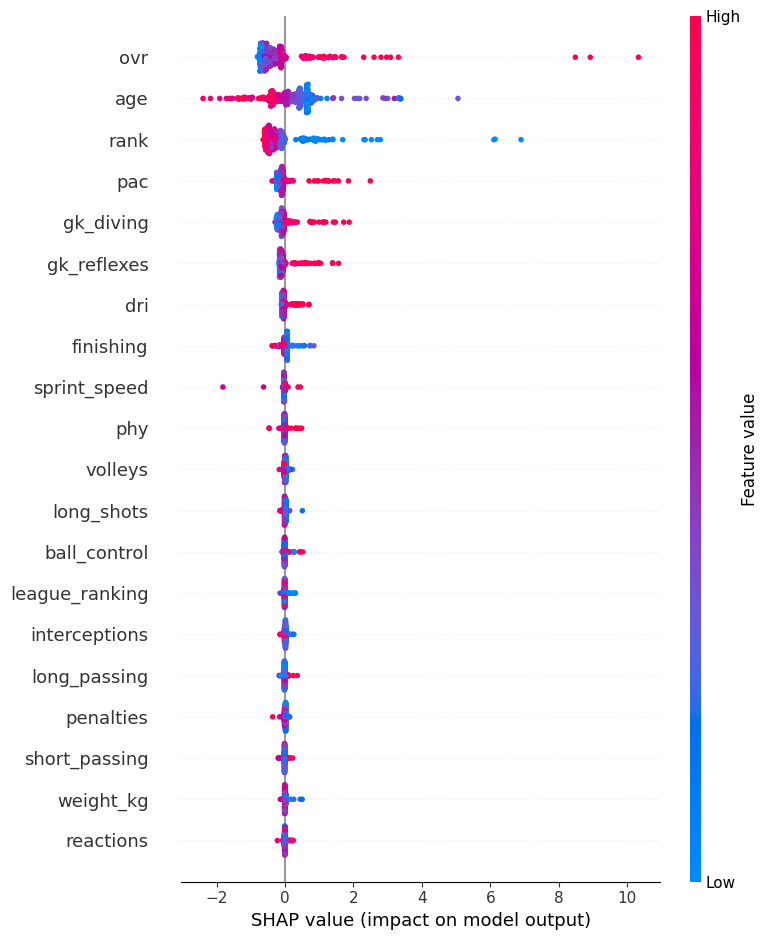

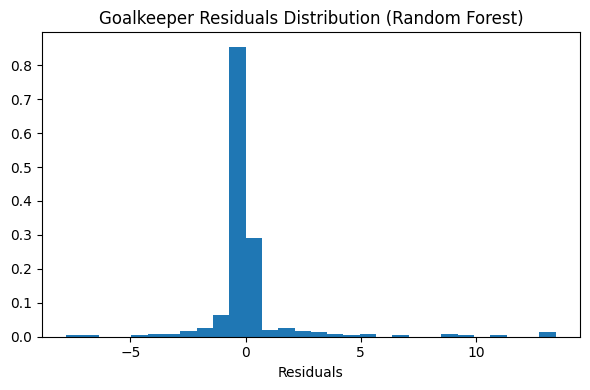

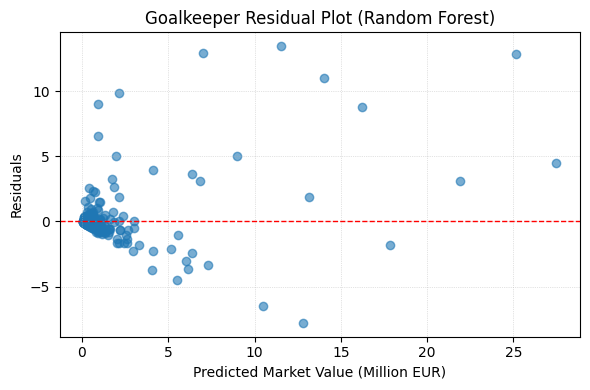

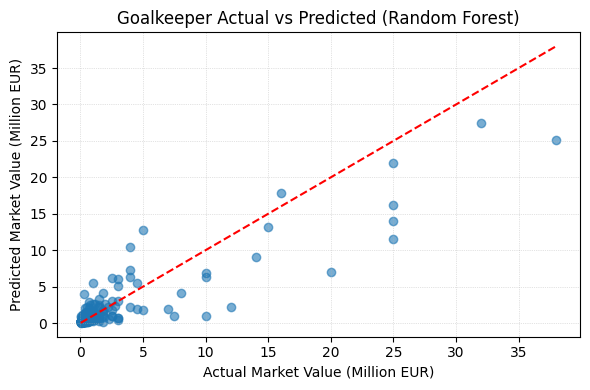

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import seaborn as sns

# 1. 读取处理好的训练集和测试集
train_df = pd.read_csv('/content/drive/MyDrive/fc25_train_GK.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/fc25_test_GK.csv')

# 2. 构造 X_train, y_train, X_test, y_test
exclude = ['market_value_million']
X_train = train_df.drop(columns=exclude)
y_train = train_df['market_value_million']
X_test  = test_df.drop(columns=exclude)
y_test  = test_df['market_value_million']

# 4. SHAP 特征重要性 (使用 TreeExplainer)
explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_test)

# 5. 全局重要性条形图
shap.summary_plot(shap_values, X_test, plot_type="bar",
    feature_names=X_test.columns,
    max_display=20)

# 6. Beeswarm 关系图
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns,
    max_display=20)

# 7. 残差分析
residuals = y_test - y_pred_1


# 1) 残差分布直方图
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30,density=True)
plt.xlabel("Residuals")
plt.title("Goalkeeper Residuals Distribution (Random Forest)")
plt.tight_layout()
plt.show()

# 2) 预测值 vs 残差 散点图
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_1, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Market Value (Million EUR)")
plt.ylabel("Residuals")
plt.title("Goalkeeper Residual Plot (Random Forest)")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# 3) 实际值 vs 预测值 散点图（替代 Q-Q 图）
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_1, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 理想参考线
plt.xlabel("Actual Market Value (Million EUR)")
plt.ylabel("Predicted Market Value (Million EUR)")
plt.title("Goalkeeper Actual vs Predicted (Random Forest)")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

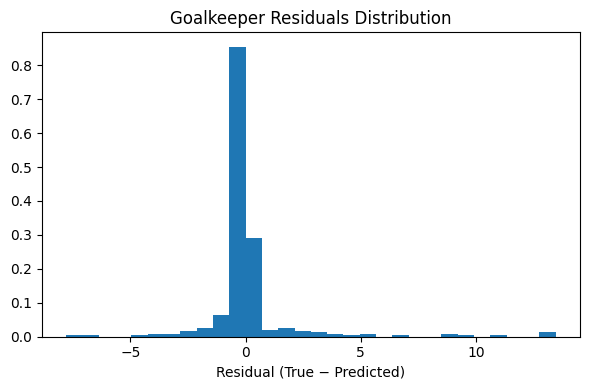

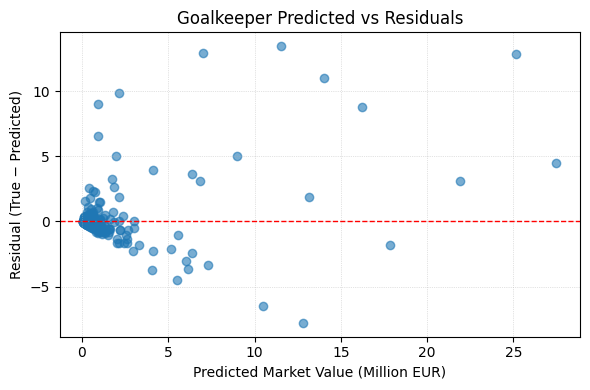

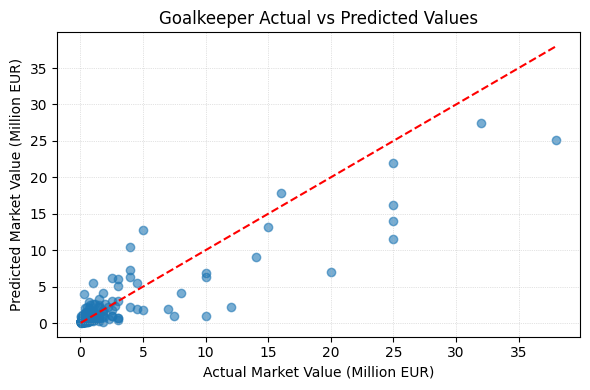

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# 生成残差
residuals = y_test - y_pred_1

# 1) 残差分布直方图
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, density=True)
plt.xlabel("Residual (True − Predicted)")
plt.title("Goalkeeper Residuals Distribution")
plt.tight_layout()
plt.show()

# 2) 预测值 vs 残差 散点图
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_1, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Market Value (Million EUR)")
plt.ylabel("Residual (True − Predicted)")
plt.title("Goalkeeper Predicted vs Residuals")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# 3) 实际值 vs 预测值 散点图（替代 Q-Q 图）
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_1, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 理想参考线
plt.xlabel("Actual Market Value (Million EUR)")
plt.ylabel("Predicted Market Value (Million EUR)")
plt.title("Goalkeeper Actual vs Predicted Values")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

XGBoost

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 读取数据
df = pd.read_csv('/content/drive/MyDrive/fc25_train_GK.csv')  # 替换成你的路径

# 2. 构造特征矩阵 X 和目标 y
exclude = ['market_value_million']
X = df.drop(columns=exclude)
y = df['market_value_million']

# 3. 模型初始化（Baseline XGBoost）
# 默认 objective='reg:squarederror'
xgb_params = {
    'n_estimators'   : 100,
    'learning_rate'  : 0.1,
    'max_depth'      : 3,
    'random_state'   : 42,
    'n_jobs'         : -1,
    'verbosity'      : 0
}

# 4. 5 个不同 seed × 5 折交叉验证
seeds    = [91, 22, 67, 2025, 623]
n_splits = 5

rmse_list, mae_list, r2_list = [], [], []

for seed in seeds:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(**xgb_params)
        model.fit(X_tr, y_tr)

        y_pred = model.predict(X_val)
        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        mae_list.append(mean_absolute_error(y_val, y_pred))
        r2_list.append(r2_score(y_val, y_pred))

# 5. 汇总并打印结果
print("XGBRegressor — 5 seeds × 5 folds 验证结果：")
print(f"Total folds: {len(rmse_list)}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE : {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"R²  : {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")


XGBRegressor — 5 seeds × 5 folds 验证结果：
Total folds: 25
RMSE: 1.9349 ± 0.3848
MAE : 0.7709 ± 0.1112
R²  : 0.7262 ± 0.1107


In [ ]:
import pandas as pd
from xgboost import XGBRegressor

# —— 1. 读取训练集 & 预测集 CSV ——
train_path = '/content/drive/MyDrive/fc25_train_GK.csv'    # 或者本地路径
test_path  = '/content/drive/MyDrive/fc25_test_GK.csv'     # 请替换为实际路径

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

exclude = ['market_value_million']

X_train = df_train.drop(columns=exclude)
y_train = df_train['market_value_million']

X_test = df_test.drop(columns=exclude)
y_test = df_test['market_value_million']

# —— 2. 调优后最佳参数 ——

# —— 3. 训练 & 预测 ——
model_default = XGBRegressor(**xgb_params)
model_default.fit(X_train, y_train)

y_pred_2_a = model_default.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_2_a))
mae  = mean_absolute_error(y_test, y_pred_2_a)
r2   = r2_score(y_test, y_pred_2_a)

print("Test Set Evaluation (XGBRegressor):")
print(f"Samples: {len(y_test)}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

Test Set Evaluation (XGBRegressor):
Samples: 334
RMSE: 1.8533
MAE : 0.7413
R²  : 0.8178


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import randint, uniform
from google.colab import drive

# —— 1. 挂载 Google Drive 并读取数据 ——
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/fc25_train_GK.csv')
X = df.drop(columns=['market_value_million'])
y = df['market_value_million']

# —— 2. 基础模型 & MAE scorer ——
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# —— 3. 连续分布的超参区间 ——
param_dist = {
    'n_estimators'     : randint(120, 250),       # 100–500 棵树
    'learning_rate'    : uniform(0.05, 0.05),     # 0.01–0.20
    'max_depth'        : randint(3, 7),          # 3–10 层
    'subsample'        : uniform(0.8, 0.2),       # 0.6–1.0
    'colsample_bytree' : uniform(0.8, 0.2),       # 0.6–1.0
}

# —— 4. 5 折 CV + 100 次随机搜索 ——
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rand_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring=mae_scorer,
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# —— 5. 运行调参 & 输出结果 ——
rand_search.fit(X, y)

print("最佳 MAE:", -rand_search.best_score_)
print("最佳参数:", rand_search.best_params_)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fitting 5 folds for each of 100 candidates, totalling 500 fits
最佳 MAE: 0.7255453608902347
最佳参数: {'colsample_bytree': np.float64(0.8471969839497911), 'learning_rate': np.float64(0.0628034161380662), 'max_depth': 5, 'n_estimators': 134, 'subsample': np.float64(0.8221781641623663)}


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 读取数据
df = pd.read_csv('/content/drive/MyDrive/fc25_train_GK.csv')
X = df.drop(columns=['market_value_million'])
y = df['market_value_million']

# 2. 调优后最佳参数
best_params = rand_search.best_params_

# 3. 构造模型


# 4. 5 seeds × 5-fold CV
seeds    = [91, 22, 67, 2025, 623]
n_splits = 5

rmse_list, mae_list, r2_list = [], [], []

for seed in seeds:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(**best_params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        mae_list.append(mean_absolute_error(y_val, y_pred))
        r2_list.append(r2_score(y_val, y_pred))

# 5. 打印结果
print("Tuned XGBRegressor — 5 seeds × 5 folds on Training Set:")
print(f"Total folds: {len(rmse_list)}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE : {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"R²  : {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")


Tuned XGBRegressor — 5 seeds × 5 folds on Training Set:
Total folds: 25
RMSE: 1.9968 ± 0.4245
MAE : 0.7630 ± 0.1184
R²  : 0.7037 ± 0.1432


In [ ]:
import pandas as pd
from xgboost import XGBRegressor

# —— 1. 读取训练集 & 预测集 CSV ——
train_path = '/content/drive/MyDrive/fc25_train_GK.csv'    # 或者本地路径
test_path  = '/content/drive/MyDrive/fc25_test_GK.csv'     # 请替换为实际路径

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

exclude = ['market_value_million']

X_train = df_train.drop(columns=exclude)
y_train = df_train['market_value_million']

X_test = df_test.drop(columns=exclude)
y_test = df_test['market_value_million']

# —— 2. 调优后最佳参数 ——
best_params = rand_search.best_params_

# —— 3. 训练 & 预测 ——
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

y_pred_2 = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_2))
mae  = mean_absolute_error(y_test, y_pred_2)
r2   = r2_score(y_test, y_pred_2)

print("Test Set Evaluation (XGBRegressor):")
print(f"Samples: {len(y_test)}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")



Test Set Evaluation (XGBRegressor):
Samples: 334
RMSE: 1.9637
MAE : 0.7314
R²  : 0.7955


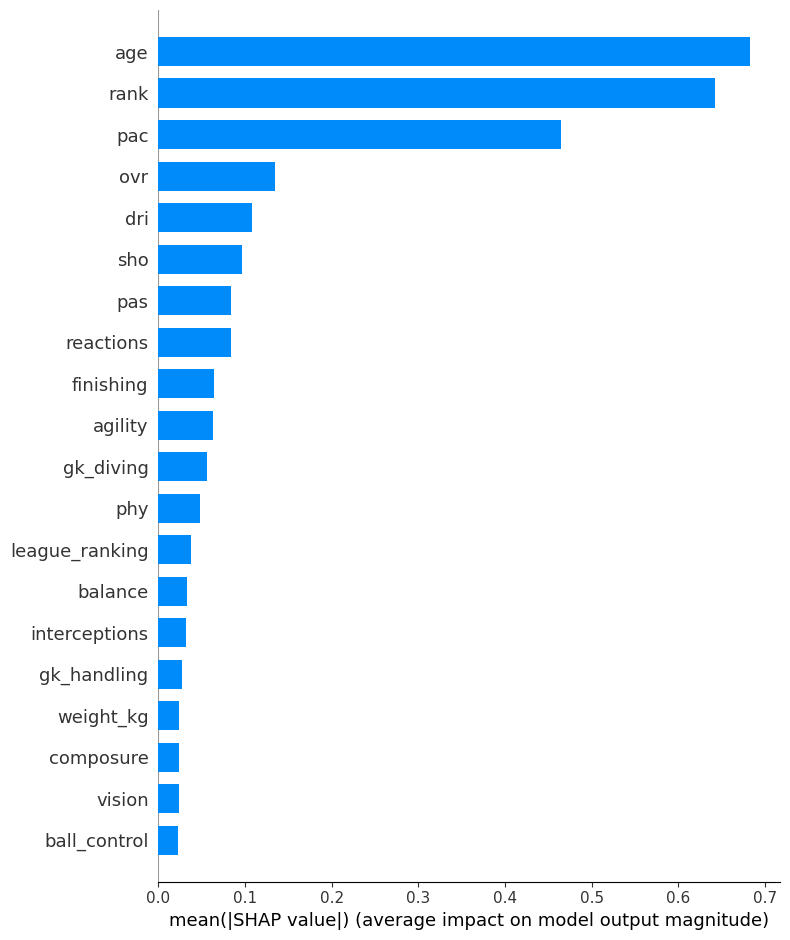

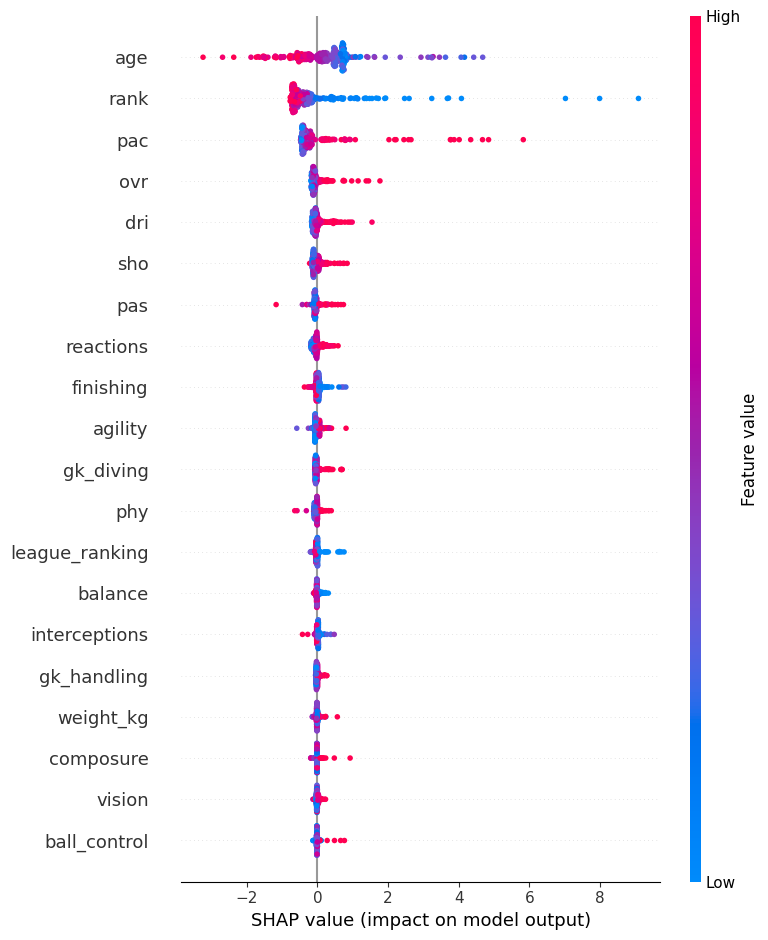

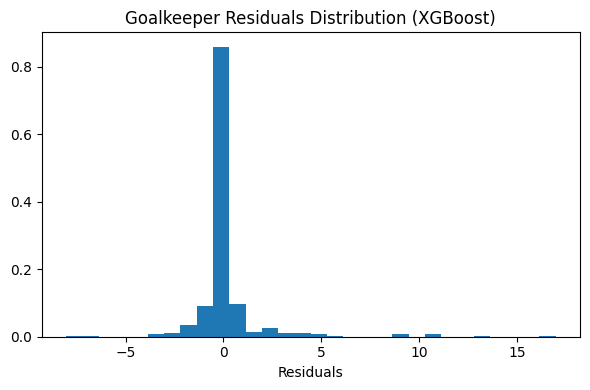

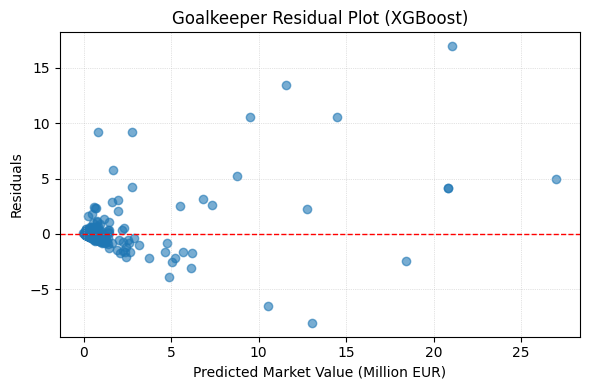

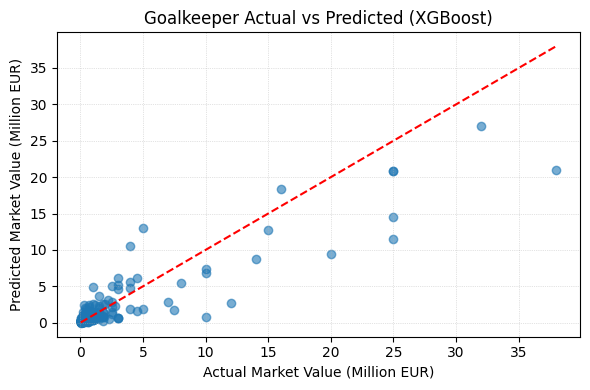

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import seaborn as sns

# 1. 读取处理好的训练集和测试集
train_df = pd.read_csv('/content/drive/MyDrive/fc25_train_GK.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/fc25_test_GK.csv')

# 2. 构造 X_train, y_train, X_test, y_test
exclude = ['market_value_million']
X_train = train_df.drop(columns=exclude)
y_train = train_df['market_value_million']
X_test  = test_df.drop(columns=exclude)
y_test  = test_df['market_value_million']


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar",
    feature_names=X_test.columns,
    max_display=20)

# 6. Beeswarm 关系图
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns,
    max_display=20)


# 生成残差
residuals = y_test - y_pred_2

# 1) 残差分布直方图
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30,density=True)
plt.xlabel("Residuals")
plt.title("Goalkeeper Residuals Distribution (XGBoost)")
plt.tight_layout()
plt.show()

# 2) 预测值 vs 残差 散点图
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_2, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Market Value (Million EUR)")
plt.ylabel("Residuals")
plt.title("Goalkeeper Residual Plot (XGBoost)")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# 3) 实际值 vs 预测值 散点图（替代 Q-Q 图）
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_2, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 理想参考线
plt.xlabel("Actual Market Value (Million EUR)")
plt.ylabel("Predicted Market Value (Million EUR)")
plt.title("Goalkeeper Actual vs Predicted (XGBoost)")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

LightGBM

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 读取已处理好的训练集
train_file = '/content/drive/MyDrive/fc25_train_GK.csv'
df = pd.read_csv(train_file)

# 2. 构造特征矩阵 X 和目标向量 y
exclude = ['market_value_million']
X = df.drop(columns=exclude)
y = df['market_value_million']

# 3. 定义 LightGBM 模型（基线参数）
lgbm = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# 4. 5 折 × 5 个随机种子 CV
seeds = [91, 22, 67, 2025, 623]
n_splits = 5

rmse_list, mae_list, r2_list = [], [], []

for seed in seeds:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 训练并预测
        lgbm.fit(X_tr, y_tr)
        y_pred = lgbm.predict(X_val)

        # 计算指标
        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        mae_list.append(mean_absolute_error(y_val, y_pred))
        r2_list.append(r2_score(y_val, y_pred))

# 5. 汇总并打印
print("LightGBM 5-seed, 5-fold CV on Training Set:")
print(f"Total folds: {len(rmse_list)}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE : {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"R²  : {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")


LightGBM 5-seed, 5-fold CV on Training Set:
Total folds: 25
RMSE: 2.1108 ± 0.3927
MAE : 0.8561 ± 0.1321
R²  : 0.6775 ± 0.1313


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer, mean_absolute_error

# 1. 读取门将子集训练集
train_file = '/content/drive/MyDrive/fc25_train_GK.csv'
df = pd.read_csv(train_file)

# 2. 构造特征矩阵 X 和目标 y
exclude = ['market_value_million']
X = df.drop(columns=exclude)
y = df['market_value_million']

# 3. 定义超参数分布
param_dist = {
    'n_estimators':       randint(100, 300),    # 100–500 棵树
    'learning_rate':      uniform(0.03, 0.07),  # 0.01–0.10
    'num_leaves':         randint(20, 60),     # 20–150 叶子数
    'max_depth':          randint(3, 8),       # 3–12 层
    'min_child_samples':  randint(5, 40),       # 5–50 叶子最小样本
    'subsample':          uniform(0.7, 0.3),    # 0.6–1.0 行采样
    'colsample_bytree':   uniform(0.7, 0.3),
}

# 4. 设置 5-Fold CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 5. 定义模型与 RandomizedSearchCV（MAE 作为评分）
lgbm = LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=100,               # 尝试 80 组超参
    scoring=mae_scorer,      # 最小化 MAE
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=2,
    refit=True
)

# 6. 执行搜索
search.fit(X, y)

# 7. 输出最优超参与 CV MAE
best_params = search.best_params_
best_mae    = -search.best_score_

print("Best hyperparameters for LightGBM (MAE):")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV MAE: {best_mae:.4f} Million EUR")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters for LightGBM (MAE):
  colsample_bytree: 0.8943070361624086
  learning_rate: 0.030036426389672105
  max_depth: 7
  min_child_samples: 7
  n_estimators: 202
  num_leaves: 25
  subsample: 0.8532241907732696
Best CV MAE: 0.7707 Million EUR


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 读取训练集
df = pd.read_csv('/content/drive/MyDrive/fc25_train_GK.csv')

# 2. 准备 X, y
exclude = ['market_value_million']
X = df.drop(columns=exclude)
y = df['market_value_million']

# 3. 获取已调优的最佳模型
best_lgbm = search.best_estimator_

# 4. 5-seed × 5-fold CV
seeds = [91,22,67,2025,623]
kf_list = []
rmse, mae, r2 = [], [], []

for seed in seeds:
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        best_lgbm.fit(X_tr, y_tr)
        pred = best_lgbm.predict(X_val)
        rmse.append(np.sqrt(mean_squared_error(y_val, pred)))
        mae.append(mean_absolute_error(y_val, pred))
        r2.append(r2_score(y_val, pred))

print("Tuned LightGBM — 5-seed, 5-fold CV:")
print(f"RMSE: {np.mean(rmse):.4f} ± {np.std(rmse):.4f}")
print(f"MAE : {np.mean(mae):.4f} ± {np.std(mae):.4f}")
print(f"R²  : {np.mean(r2):.4f} ± {np.std(r2):.4f}")


Tuned LightGBM — 5-seed, 5-fold CV:
RMSE: 2.0818 ± 0.4196
MAE : 0.7904 ± 0.1179
R²  : 0.6804 ± 0.1427


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ——— 1. 读取处理好的测试集 ———
df_test = pd.read_csv('/content/drive/MyDrive/fc25_test_GK.csv')

# ——— 2. 构造 X_test, y_test ———
exclude = ['market_value_million']
X_test = df_test.drop(columns=exclude)
y_test = df_test['market_value_million']

# ——— 3. 用调优后的最佳模型做预测 ———
best_lgbm.fit(X, y)
y_pred_3 = best_lgbm.predict(X_test)

# ——— 4. 计算并打印指标 ———
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_3))
mae_test  = mean_absolute_error(y_test, y_pred_3)
r2_test   = r2_score(y_test, y_pred_3)

print("Tuned LightGBM Test Set Evaluation (No5 GK cols):")
print(f"Samples: {len(y_test)}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"R²  : {r2_test:.4f}")


Tuned LightGBM Test Set Evaluation (No5 GK cols):
Samples: 334
RMSE: 2.0479
MAE : 0.7503
R²  : 0.7775


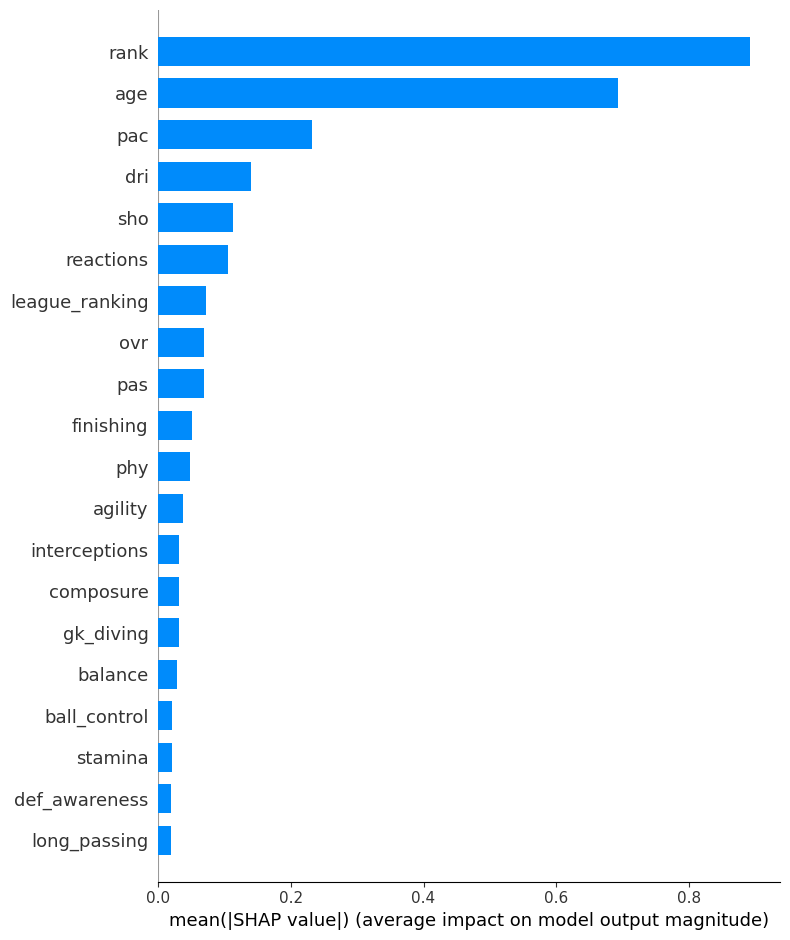

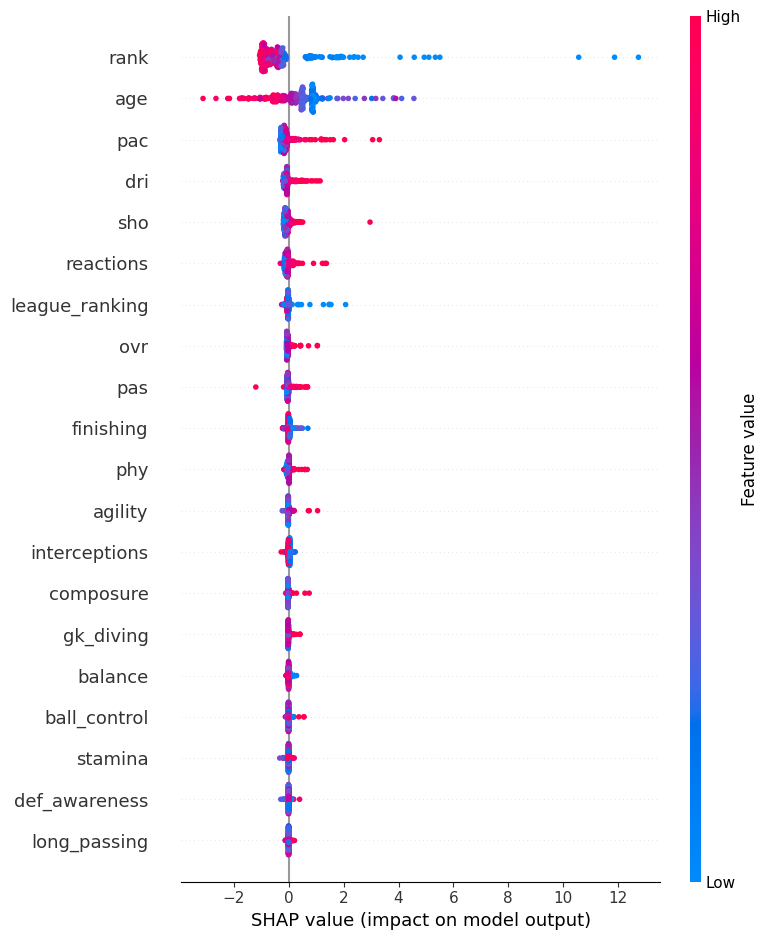

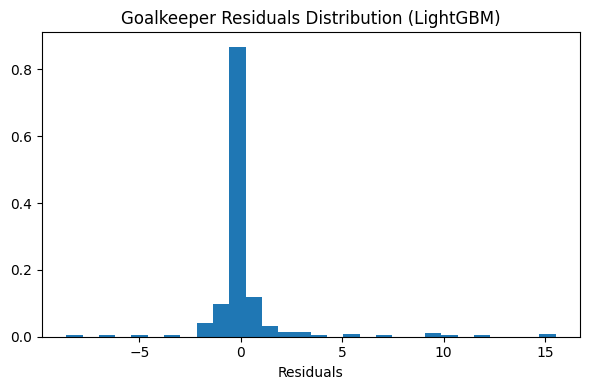

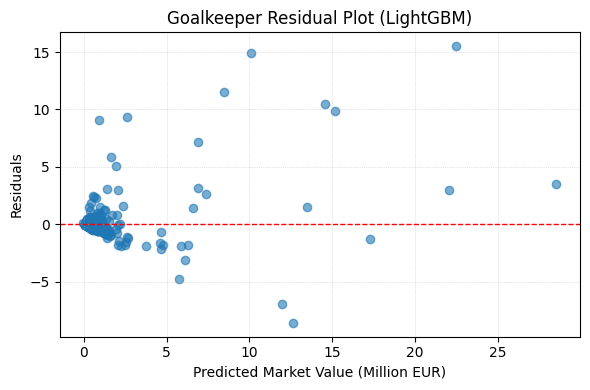

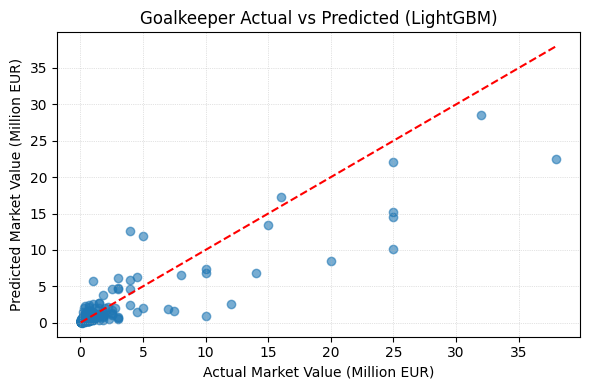

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import seaborn as sns

# 1. 读取处理好的训练集和测试集
train_df = pd.read_csv('/content/drive/MyDrive/fc25_train_GK.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/fc25_test_GK.csv')

# 2. 构造 X_train, y_train, X_test, y_test
exclude = ['market_value_million']
X_train = train_df.drop(columns=exclude)
y_train = train_df['market_value_million']
X_test  = test_df.drop(columns=exclude)
y_test  = test_df['market_value_million']


# 4. SHAP 特征重要性 (使用 TreeExplainer)
explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_test)

# 5. 全局重要性条形图
shap.summary_plot(shap_values, X_test, plot_type="bar",
    feature_names=X_test.columns,
    max_display=20)

# 6. Beeswarm 关系图
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns,
    max_display=20)

# 7. 残差分析
residuals = y_test - y_pred_3


# 1) 残差分布直方图
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30,density=True)
plt.xlabel("Residuals")
plt.title("Goalkeeper Residuals Distribution (LightGBM)")
plt.tight_layout()
plt.show()

# 2) 预测值 vs 残差 散点图
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_3, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Market Value (Million EUR)")
plt.ylabel("Residuals")
plt.title("Goalkeeper Residual Plot (LightGBM)")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# 3) 实际值 vs 预测值 散点图（替代 Q-Q 图）
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_3, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 理想参考线
plt.xlabel("Actual Market Value (Million EUR)")
plt.ylabel("Predicted Market Value (Million EUR)")
plt.title("Goalkeeper Actual vs Predicted (LightGBM)")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()